In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 12)
plt.rcParams['font.size'] = 10

print("Loading Pola Ruang data...")
print("="*80)

Loading Pola Ruang data...


In [2]:
# ========== RTRW VS SATELLITE REALITY ANALYSIS ==========
print("\n" + "="*80)
print("PHASE 2: RTRW OFFICIAL ZONING VS SATELLITE REALITY (LULC)")
print("="*80)
print("\nChallenge Question: Does the Official Zoning map say 'Forest,' but the Satellite says 'Dense Housing'?")
print("Identifying these discrepancies is where the value lies.")
print("\n" + "="*80)

# Load grid data with LULC (satellite reality)
print("\nLoading grid data with satellite LULC...")
grid_tangsel = gpd.read_parquet('../../../output/grid_integration/grid_tangsel_integrated.parquet')
grid_oku = gpd.read_parquet('../../../output/grid_integration/grid_oku_integrated.parquet')

print(f"✓ Tangsel: {len(grid_tangsel):,} grids with LULC data")
print(f"✓ OKU: {len(grid_oku):,} grids with LULC data")

# Load RTRW data from parent folder
print("\nLoading RTRW official zoning...")
rtrw_tangsel = gpd.read_file('../RTRW_KOTA_TANGERANG_SELATAN.geojson')
rtrw_oku = gpd.read_file('../RTRW_OGAN_KOMERING_ULU.geojson')

print(f"✓ RTRW Tangsel: {len(rtrw_tangsel):,} polygons")
print(f"✓ RTRW OKU: {len(rtrw_oku):,} polygons")


PHASE 2: RTRW OFFICIAL ZONING VS SATELLITE REALITY (LULC)

Challenge Question: Does the Official Zoning map say 'Forest,' but the Satellite says 'Dense Housing'?
Identifying these discrepancies is where the value lies.


Loading grid data with satellite LULC...
✓ Tangsel: 67,649 grids with LULC data
✓ OKU: 1,529,054 grids with LULC data

Loading RTRW official zoning...
✓ RTRW Tangsel: 25 polygons
✓ RTRW OKU: 21 polygons


In [3]:
# Categorize RTRW zones into broad categories
print("\nCategorizing RTRW zones...")

# Tangsel RTRW categories (using namobj and rtrkaw columns)
rtrw_tangsel['zone_category'] = 'Other'
rtrw_tangsel.loc[rtrw_tangsel['namobj'].str.contains('Permukiman', case=False, na=False), 'zone_category'] = 'Residential'
rtrw_tangsel.loc[rtrw_tangsel['namobj'].str.contains('Industri', case=False, na=False), 'zone_category'] = 'Industrial'
rtrw_tangsel.loc[rtrw_tangsel['namobj'].str.contains('RTH|Hijau|Taman|Ruang Terbuka Hijau', case=False, na=False), 'zone_category'] = 'Green Space'
rtrw_tangsel.loc[rtrw_tangsel['rtrkaw'] == 1, 'zone_category'] = 'Protected'  # rtrkaw=1 means Kawasan Lindung

print("Tangsel RTRW Categories:")
for cat, count in rtrw_tangsel['zone_category'].value_counts().items():
    pct = (count / len(rtrw_tangsel)) * 100
    print(f"  • {cat}: {count:,} polygons ({pct:.1f}%)")

# OKU RTRW categories (using namobj and rtrkaw columns)
rtrw_oku['zone_category'] = 'Other'
rtrw_oku.loc[rtrw_oku['namobj'].str.contains('Pertanian|Hortikultura', case=False, na=False), 'zone_category'] = 'Agriculture'
rtrw_oku.loc[rtrw_oku['namobj'].str.contains('Permukiman', case=False, na=False), 'zone_category'] = 'Residential'
rtrw_oku.loc[rtrw_oku['namobj'].str.contains('Hutan Produksi', case=False, na=False), 'zone_category'] = 'Production Forest'
rtrw_oku.loc[rtrw_oku['namobj'].str.contains('Industri', case=False, na=False), 'zone_category'] = 'Industrial'
rtrw_oku.loc[rtrw_oku['rtrkaw'] == 1, 'zone_category'] = 'Protected'  # rtrkaw=1 means Kawasan Lindung
rtrw_oku.loc[rtrw_oku['namobj'].str.contains('Hutan Lindung', case=False, na=False), 'zone_category'] = 'Protected'

print("\nOKU RTRW Categories:")
for cat, count in rtrw_oku['zone_category'].value_counts().items():
    pct = (count / len(rtrw_oku)) * 100
    print(f"  • {cat}: {count:,} polygons ({pct:.1f}%)")

print("\n✓ RTRW categorization complete")


Categorizing RTRW zones...
Tangsel RTRW Categories:
  • Protected: 11 polygons (44.0%)
  • Other: 9 polygons (36.0%)
  • Industrial: 2 polygons (8.0%)
  • Green Space: 2 polygons (8.0%)
  • Residential: 1 polygons (4.0%)

OKU RTRW Categories:
  • Other: 6 polygons (28.6%)
  • Protected: 4 polygons (19.0%)
  • Agriculture: 4 polygons (19.0%)
  • Production Forest: 4 polygons (19.0%)
  • Residential: 2 polygons (9.5%)
  • Industrial: 1 polygons (4.8%)

✓ RTRW categorization complete


In [4]:
# Spatial join: Grid centroids with RTRW zones
print("\nPerforming spatial join...")
print("(Using grid centroids for faster computation)")

# Create point geometries from grid centroids
grid_tangsel_pts = grid_tangsel.copy()
grid_tangsel_pts['geometry'] = grid_tangsel_pts.geometry.centroid

grid_oku_pts = grid_oku.copy()
grid_oku_pts['geometry'] = grid_oku_pts.geometry.centroid

# Spatial join
tangsel_joined = gpd.sjoin(grid_tangsel_pts, rtrw_tangsel[['zone_category', 'geometry']],
                           how='left', predicate='within')
oku_joined = gpd.sjoin(grid_oku_pts, rtrw_oku[['zone_category', 'geometry']],
                       how='left', predicate='within')

print(f"✓ Tangsel: {tangsel_joined['zone_category'].notna().sum():,} grids matched with RTRW zones")
print(f"✓ OKU: {oku_joined['zone_category'].notna().sum():,} grids matched with RTRW zones")


Performing spatial join...
(Using grid centroids for faster computation)


/tmp/ipykernel_106508/3427749605.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_tangsel_pts['geometry'] = grid_tangsel_pts.geometry.centroid
/tmp/ipykernel_106508/3427749605.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_oku_pts['geometry'] = grid_oku_pts.geometry.centroid


✓ Tangsel: 66,769 grids matched with RTRW zones
✓ OKU: 1,492,186 grids matched with RTRW zones


In [5]:
# Detect discrepancies between RTRW (plan) and LULC (reality)
print("\nDetecting discrepancies...")

def detect_discrepancy(row):
    """Detect if RTRW zone conflicts with satellite LULC reality"""
    zone = row.get('zone_category', 'Unknown')
    lulc = row.get('lulc_name', 'Unknown')
    
    discrepancies = []
    
    # Rule 1: Protected/Green Space but actually Built
    if zone in ['Protected', 'Green Space'] and lulc == 'Built Area':
        discrepancies.append('Protected→Built')
    
    # Rule 2: Agriculture zone but actually Built
    if zone == 'Agriculture' and lulc == 'Built Area':
        discrepancies.append('Agriculture→Built')
    
    # Rule 3: Production Forest but actually Built or Crops
    if zone == 'Production Forest' and lulc in ['Built Area', 'Crops']:
        discrepancies.append('Forest→Developed')
    
    # Rule 4: Residential zone but actually Agriculture (underdevelopment)
    if zone == 'Residential' and lulc in ['Crops', 'Rangeland', 'Trees']:
        discrepancies.append('Residential→Undeveloped')
    
    # Rule 5: Industrial zone but not developed yet
    if zone == 'Industrial' and lulc in ['Crops', 'Rangeland', 'Trees', 'Bare Ground']:
        discrepancies.append('Industrial→Undeveloped')
    
    return ', '.join(discrepancies) if discrepancies else 'Compliant'

tangsel_joined['discrepancy'] = tangsel_joined.apply(detect_discrepancy, axis=1)
oku_joined['discrepancy'] = oku_joined.apply(detect_discrepancy, axis=1)

print("✓ Discrepancy detection complete")


Detecting discrepancies...
✓ Discrepancy detection complete


In [6]:
# Calculate compliance statistics
print("\n" + "="*80)
print("COMPLIANCE STATISTICS")
print("="*80)

# Count discrepancies
tangsel_discrepancy_count = (tangsel_joined['discrepancy'] != 'Compliant').sum()
oku_discrepancy_count = (oku_joined['discrepancy'] != 'Compliant').sum()

tangsel_total = len(tangsel_joined[tangsel_joined['zone_category'].notna()])
oku_total = len(oku_joined[oku_joined['zone_category'].notna()])

print(f"\nTangerang Selatan:")
print(f"  Total grids analyzed: {tangsel_total:,}")
print(f"  Compliant grids: {tangsel_total - tangsel_discrepancy_count:,}")
print(f"  Discrepancy grids: {tangsel_discrepancy_count:,}")
print(f"  Compliance rate: {((tangsel_total - tangsel_discrepancy_count)/tangsel_total)*100:.1f}%")

print(f"\nOgan Komering Ulu:")
print(f"  Total grids analyzed: {oku_total:,}")
print(f"  Compliant grids: {oku_total - oku_discrepancy_count:,}")
print(f"  Discrepancy grids: {oku_discrepancy_count:,}")
print(f"  Compliance rate: {((oku_total - oku_discrepancy_count)/oku_total)*100:.1f}%")

# Detailed breakdown
print("\n" + "="*80)
print("DISCREPANCY BREAKDOWN")
print("="*80)

print("\nTANGSEL:")
tangsel_disc_types = tangsel_joined[tangsel_joined['discrepancy'] != 'Compliant']['discrepancy'].value_counts()
for disc_type, count in tangsel_disc_types.items():
    pct = (count / tangsel_total) * 100
    print(f"  • {disc_type}: {count:,} grids ({pct:.2f}%)")

print("\nOKU:")
oku_disc_types = oku_joined[oku_joined['discrepancy'] != 'Compliant']['discrepancy'].value_counts()
for disc_type, count in oku_disc_types.items():
    pct = (count / oku_total) * 100
    print(f"  • {disc_type}: {count:,} grids ({pct:.2f}%)")


COMPLIANCE STATISTICS

Tangerang Selatan:
  Total grids analyzed: 66,769
  Compliant grids: 44,313
  Discrepancy grids: 22,456
  Compliance rate: 66.4%

Ogan Komering Ulu:
  Total grids analyzed: 1,492,186
  Compliant grids: 1,394,413
  Discrepancy grids: 97,773
  Compliance rate: 93.4%

DISCREPANCY BREAKDOWN

TANGSEL:
  • Protected→Built: 22,052 grids (33.03%)
  • Industrial→Undeveloped: 297 grids (0.44%)
  • Residential→Undeveloped: 107 grids (0.16%)

OKU:
  • Residential→Undeveloped: 50,928 grids (3.41%)
  • Forest→Developed: 28,631 grids (1.92%)
  • Agriculture→Built: 7,420 grids (0.50%)
  • Protected→Built: 6,272 grids (0.42%)
  • Industrial→Undeveloped: 4,522 grids (0.30%)



Generating discrepancy maps...
✓ Saved: output/maps/rtrw_vs_satellite_discrepancy.png


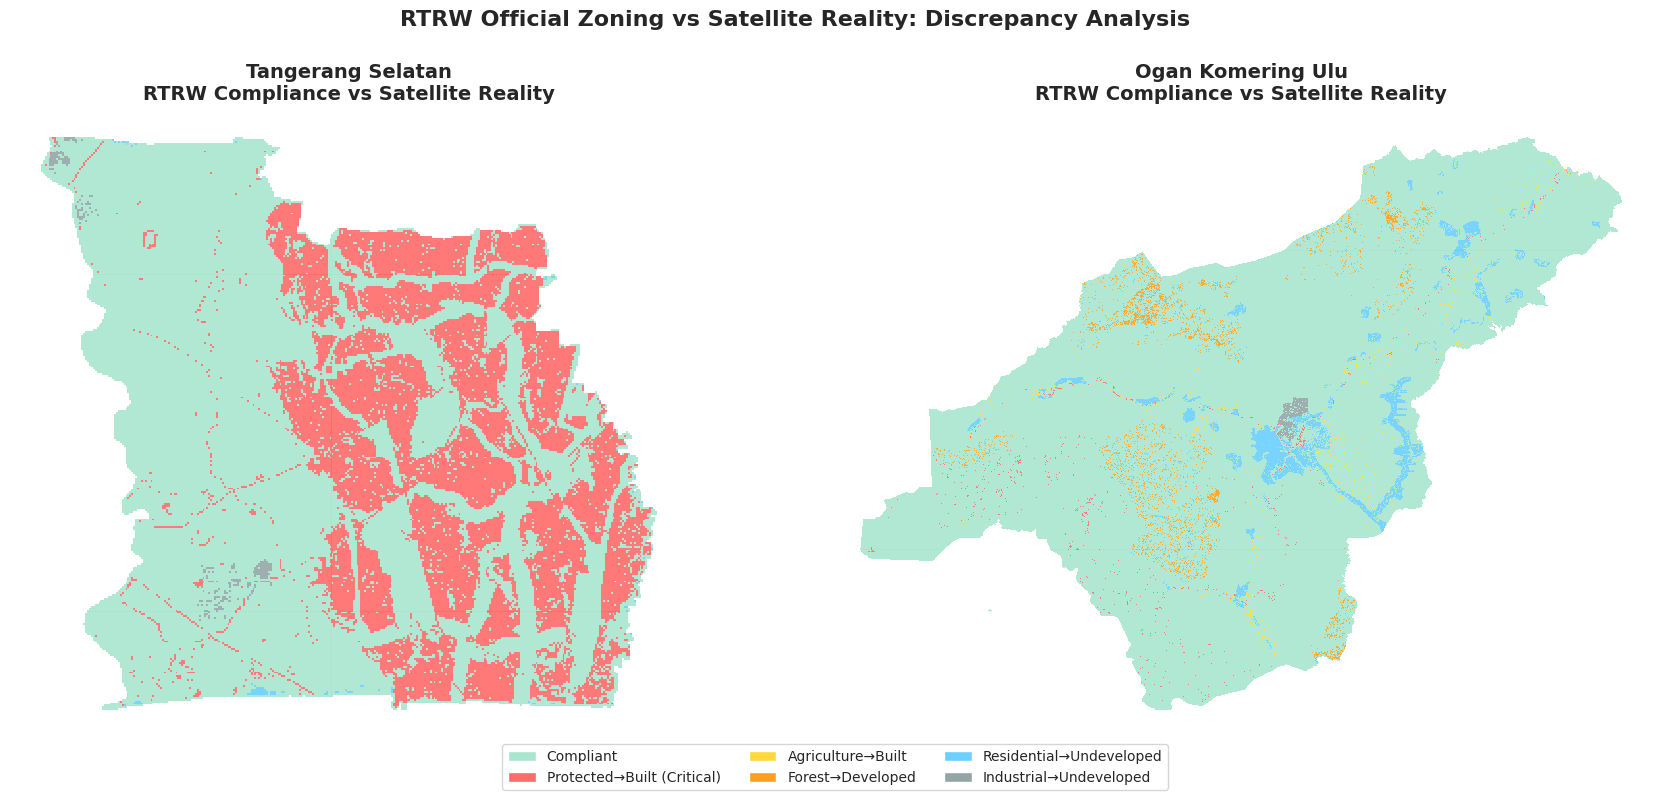

In [7]:
# Generate discrepancy visualization map
print("\nGenerating discrepancy maps...")

import os
os.makedirs('../../../output/maps', exist_ok=True)

# Restore original polygon geometry (not centroid points)
tangsel_joined_polygons = tangsel_joined.copy()
tangsel_joined_polygons['geometry'] = grid_tangsel.loc[tangsel_joined.index, 'geometry'].values

oku_joined_polygons = oku_joined.copy()
oku_joined_polygons['geometry'] = grid_oku.loc[oku_joined.index, 'geometry'].values

# Discrepancy color map (darker colors for better visibility)
disc_colors = {
    'Compliant': '#a8e6cf',  # Medium green
    'Protected→Built': '#ff6b6b',  # Strong red
    'Agriculture→Built': '#ffd93d',  # Strong yellow
    'Forest→Developed': '#ff9f1c',  # Orange
    'Residential→Undeveloped': '#6bcfff',  # Strong blue
    'Industrial→Undeveloped': '#95a5a6',  # Medium gray
}

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Tangsel map
ax1 = axes[0]
tangsel_gdf = gpd.GeoDataFrame(tangsel_joined_polygons, geometry='geometry', crs=grid_tangsel.crs)

for disc_type, color in disc_colors.items():
    subset = tangsel_gdf[tangsel_gdf['discrepancy'] == disc_type]
    if len(subset) > 0:
        subset.plot(ax=ax1, color=color, edgecolor='none', alpha=0.9, linewidth=0)

ax1.set_title('Tangerang Selatan\nRTRW Compliance vs Satellite Reality',
              fontsize=14, fontweight='bold')
ax1.axis('off')

# OKU map
ax2 = axes[1]
oku_gdf = gpd.GeoDataFrame(oku_joined_polygons, geometry='geometry', crs=grid_oku.crs)

for disc_type, color in disc_colors.items():
    subset = oku_gdf[oku_gdf['discrepancy'] == disc_type]
    if len(subset) > 0:
        subset.plot(ax=ax2, color=color, edgecolor='none', alpha=0.9, linewidth=0)

ax2.set_title('Ogan Komering Ulu\nRTRW Compliance vs Satellite Reality',
              fontsize=14, fontweight='bold')
ax2.axis('off')

# Legend
import matplotlib.patches as mpatches
legend_elements = [
    mpatches.Patch(facecolor='#a8e6cf', label='Compliant'),
    mpatches.Patch(facecolor='#ff6b6b', label='Protected→Built (Critical)'),
    mpatches.Patch(facecolor='#ffd93d', label='Agriculture→Built'),
    mpatches.Patch(facecolor='#ff9f1c', label='Forest→Developed'),
    mpatches.Patch(facecolor='#6bcfff', label='Residential→Undeveloped'),
    mpatches.Patch(facecolor='#95a5a6', label='Industrial→Undeveloped'),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, frameon=True, fontsize=10)

plt.suptitle('RTRW Official Zoning vs Satellite Reality: Discrepancy Analysis',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.savefig('../../../output/maps/rtrw_vs_satellite_discrepancy.png', dpi=300, bbox_inches='tight')
print("✓ Saved: output/maps/rtrw_vs_satellite_discrepancy.png")
plt.show()

In [8]:
# Final summary and investment implications
print("\n" + "="*80)
print("SUMMARY: RTRW VS SATELLITE REALITY")
print("="*80)

summary_data = {
    'Region': ['Tangerang Selatan', 'Ogan Komering Ulu'],
    'Total Grids Analyzed': [tangsel_total, oku_total],
    'Compliant Grids': [tangsel_total - tangsel_discrepancy_count, oku_total - oku_discrepancy_count],
    'Discrepancy Grids': [tangsel_discrepancy_count, oku_discrepancy_count],
    'Compliance Rate (%)': [
        ((tangsel_total - tangsel_discrepancy_count) / tangsel_total) * 100,
        ((oku_total - oku_discrepancy_count) / oku_total) * 100
    ]
}

df_summary = pd.DataFrame(summary_data)
print("\n", df_summary.to_string(index=False))

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

print("\nTangerang Selatan:")
print(f"  • Compliance Rate: {((tangsel_total - tangsel_discrepancy_count) / tangsel_total) * 100:.1f}%")
if len(tangsel_disc_types) > 0:
    top_disc = tangsel_disc_types.index[0]
    top_count = tangsel_disc_types.values[0]
    print(f"  • Top Discrepancy: {top_disc} ({top_count:,} grids)")
    print(f"  • Interpretation: {'High' if tangsel_discrepancy_count > tangsel_total * 0.2 else 'Moderate' if tangsel_discrepancy_count > tangsel_total * 0.1 else 'Low'} discrepancy")

print("\nOgan Komering Ulu:")
print(f"  • Compliance Rate: {((oku_total - oku_discrepancy_count) / oku_total) * 100:.1f}%")
if len(oku_disc_types) > 0:
    top_disc = oku_disc_types.index[0]
    top_count = oku_disc_types.values[0]
    print(f"  • Top Discrepancy: {top_disc} ({top_count:,} grids)")
    print(f"  • Interpretation: {'High' if oku_discrepancy_count > oku_total * 0.2 else 'Moderate' if oku_discrepancy_count > oku_total * 0.1 else 'Low'} discrepancy")

print("\n" + "="*80)
print("INVESTMENT IMPLICATIONS")
print("="*80)
print("  • High discrepancy = Risk of regulatory issues, but also development opportunities")
print("  • Low discrepancy = Predictable market, better alignment with government plans")
print("  • Protected→Built = High-risk areas, potential enforcement/rezoning")
print("  • Residential→Undeveloped = Land banking opportunities, future development zones")
print("\n" + "="*80)
print("PHASE 2 VALIDATION COMPLETE")
print("="*80)


SUMMARY: RTRW VS SATELLITE REALITY

            Region  Total Grids Analyzed  Compliant Grids  Discrepancy Grids  Compliance Rate (%)
Tangerang Selatan                 66769            44313              22456            66.367626
Ogan Komering Ulu               1492186          1394413              97773            93.447667

KEY FINDINGS

Tangerang Selatan:
  • Compliance Rate: 66.4%
  • Top Discrepancy: Protected→Built (22,052 grids)
  • Interpretation: High discrepancy

Ogan Komering Ulu:
  • Compliance Rate: 93.4%
  • Top Discrepancy: Residential→Undeveloped (50,928 grids)
  • Interpretation: Low discrepancy

INVESTMENT IMPLICATIONS
  • High discrepancy = Risk of regulatory issues, but also development opportunities
  • Low discrepancy = Predictable market, better alignment with government plans
  • Protected→Built = High-risk areas, potential enforcement/rezoning
  • Residential→Undeveloped = Land banking opportunities, future development zones

PHASE 2 VALIDATION COMPLETE



Generating OKU-only compliance map...
✓ Saved: output/maps/rtrw_compliance_oku_only.png


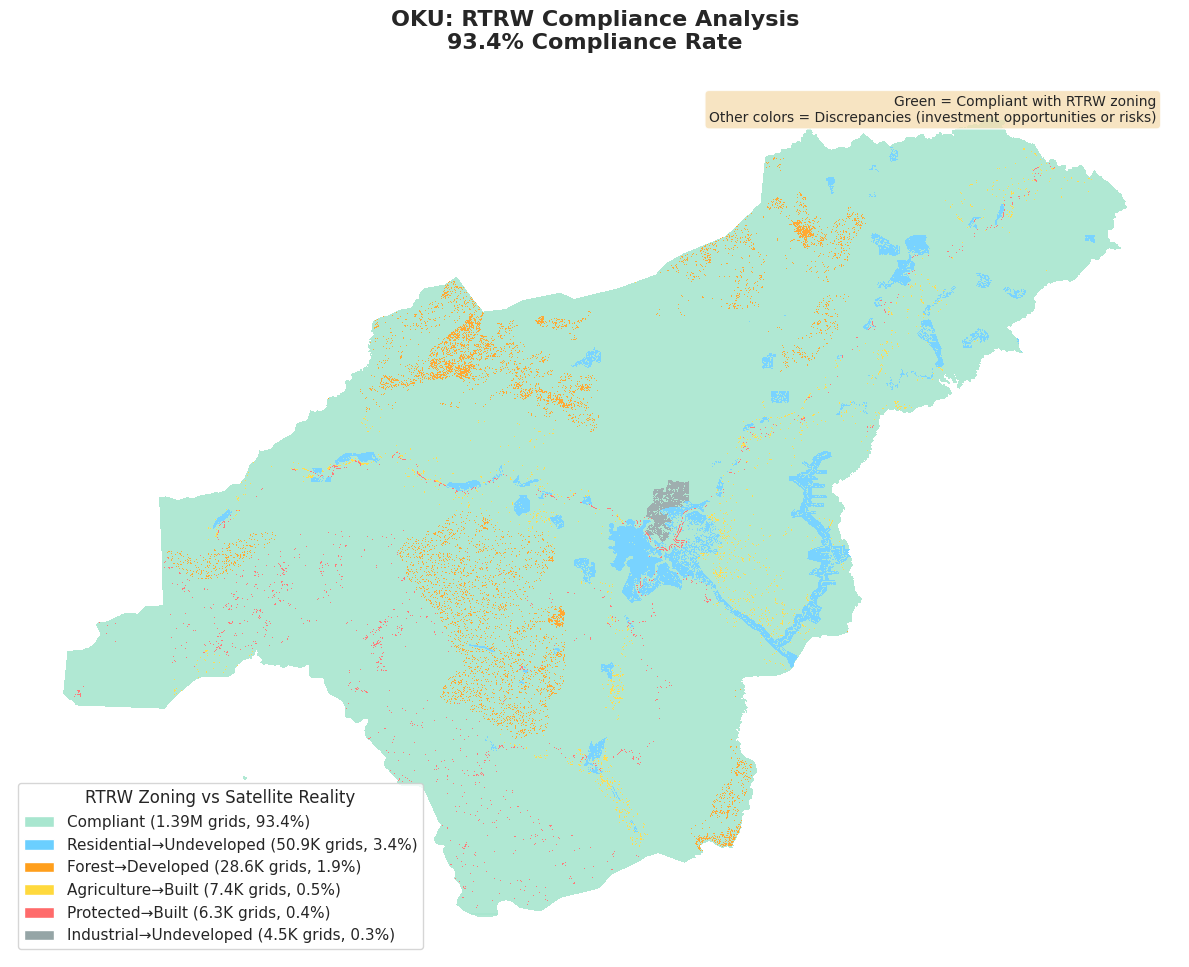

In [9]:
# Generate OKU-only compliance map for investment memo
print("\nGenerating OKU-only compliance map...")

import matplotlib.patches as mpatches

# Restore polygon geometry if needed
if 'oku_joined_polygons' not in locals():
    oku_joined_polygons = oku_joined.copy()
    oku_joined_polygons['geometry'] = grid_oku.loc[oku_joined.index, 'geometry'].values
    print("✓ Restored polygon geometry from oku_joined")

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# OKU map with polygon geometry
oku_gdf = gpd.GeoDataFrame(oku_joined_polygons, geometry='geometry', crs=grid_oku.crs)

# Plot each discrepancy type
for disc_type, color in disc_colors.items():
    subset = oku_gdf[oku_gdf['discrepancy'] == disc_type]
    if len(subset) > 0:
        subset.plot(ax=ax, color=color, edgecolor='none', alpha=0.9, linewidth=0)

ax.set_title('OKU: RTRW Compliance Analysis\n93.4% Compliance Rate',
              fontsize=16, fontweight='bold', pad=20)
ax.axis('off')

# Legend with grid counts
legend_elements = [
    mpatches.Patch(facecolor='#a8e6cf', label=f'Compliant (1.39M grids, 93.4%)'),
    mpatches.Patch(facecolor='#6bcfff', label=f'Residential→Undeveloped (50.9K grids, 3.4%)'),
    mpatches.Patch(facecolor='#ff9f1c', label=f'Forest→Developed (28.6K grids, 1.9%)'),
    mpatches.Patch(facecolor='#ffd93d', label=f'Agriculture→Built (7.4K grids, 0.5%)'),
    mpatches.Patch(facecolor='#ff6b6b', label=f'Protected→Built (6.3K grids, 0.4%)'),
    mpatches.Patch(facecolor='#95a5a6', label=f'Industrial→Undeveloped (4.5K grids, 0.3%)'),
]
ax.legend(handles=legend_elements, loc='lower left', frameon=True, fontsize=11, 
          title='RTRW Zoning vs Satellite Reality', title_fontsize=12)

# Add text annotation
textstr = 'Green = Compliant with RTRW zoning\nOther colors = Discrepancies (investment opportunities or risks)'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.98, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.savefig('../../../output/maps/rtrw_compliance_oku_only.png', dpi=300, bbox_inches='tight')
print("✓ Saved: output/maps/rtrw_compliance_oku_only.png")
plt.show()